# Predicting flood occurrence
Flood occurrences in downtown Norfolk are predicted based on rain, tide levels, water table levels, and wind speed/direction. 

In [1]:
repo = "http://cran.us.r-project.org"
library(caret)
library(ggfortify)
library(ggplot2)
library(dplyr)
library(rpart)
library(rpart.plot)
library(RSQLite)
library(DBI)
library(randomForest)
library(e1071)
library(class)

Warning message:
"package 'caret' was built under R version 3.3.3"Loading required package: lattice
Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.3.3"Warning message:
"package 'ggfortify' was built under R version 3.3.3"Warning message:
"package 'dplyr' was built under R version 3.3.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'rpart.plot' was built under R version 3.3.3"Warning message:
"package 'RSQLite' was built under R version 3.3.3"Warning message:
"package 'DBI' was built under R version 3.3.3"Warning message:
"package 'randomForest' was built under R version 3.3.3"randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:dplyr':

    combine

The followin

In [2]:
classify_knn = function(pca.data, obs_data, point, k){
  neighs = get_nn(pca.data, point, k)
  neigh_data = obs_data[neighs,]
  return(names(which.max(table(neigh_data$fld))))
}

In [3]:
get_nn = function(d, point, k){
  point = d[point, ]
  dists = sort(sqrt(rowSums((t(t(d) - point))^2)))
  close_points = names(dists)[2:k]
  return(close_points)
}

In [27]:
base_dir<- "C:/Users/Jeff/Documents/research/Sadler_3rdPaper/manuscript/"
data_dir<- "C:/Users/Jeff/Google Drive/research/Sadler_3rdPaper_Data/"
fig_dir <- paste(base_dir, "Figures/general/", sep="")
db_filename <- "floodData.sqlite"

In [73]:
con = dbConnect(RSQLite::SQLite(), dbname=paste(data_dir, db_filename, sep=""))

In [74]:
df = dbReadTable(con, 'flood_locations')

In [75]:
colnames(df)

[1] "index"      "location"   "xcoord"     "ycoord"     "count"     
 [6] "twi"        "elev_1"     "dist_to_ba" "imp"        "dist_to_wa"
[11] "is_dntn"    "Structure1" "Rim_Elevat" "Invert_Ele" "Year_Insta"
[16] "Pipe_Geome" "Horizontal" "Vertical_D" "Pipe_Lengt" "Pipe_Mater"
[21] "Year_Ins_1" "Condition"  "flood_pt"

In [76]:
in_col_names = c('elev_1',
                 'dist_to_ba',
                 'imp',
                 'dist_to_wa',
                 'Structure1',
                 'twi',
                 'Rim_Elevat',
                 'Invert_Ele',
                 'Year_Insta',
                 'Pipe_Geome',
                 'Horizontal',                 
                 'Vertical_D',
                 'Pipe_Lengt',
                 'Pipe_Mater',
                 'Vertical_D'
                )
out_col_name = 'flood_pt'
model_data = df[, c(in_col_names, out_col_name)]
model_data[,out_col_name] = model_data[,out_col_name]>0
model_data[,out_col_name] = factor(model_data[,out_col_name])

In [84]:
model_data = na.omit(model_data)

In [90]:
model_data$Structure1 = as.factor(model_data$Structure1)
model_data$Pipe_Geome = as.factor(model_data$Structure1)
model_data$Pipe_Mater = as.factor(model_data$Structure1)

In [93]:
head(model_data)

elev_1,dist_to_ba,imp,dist_to_wa,Structure1,twi,Rim_Elevat,Invert_Ele,Year_Insta,Pipe_Geome,Horizontal,Vertical_D,Pipe_Lengt,Pipe_Mater,Vertical_D.1,flood_pt
0.663456,56.5723,74738,353.265,CBNS,7.48559,4.33,2.42,1938,CBNS,9,14,25,CBNS,14,TRUE
0.641102,54.0859,78962,354.661,CBNS,7.53130,4.34,1.85,1938,CBNS,11,18,25,CBNS,18,TRUE
0.877023,20.4813,90165,505.969,CBNS,8.72800,4.98,1.21,1938,CBNS,24,0,240,CBNS,0,TRUE
0.975468,463.2510,87607,357.142,CBNS,7.75242,5.59,3.28,1938,CBNS,15,0,30,CBNS,0,TRUE
1.023950,168.7280,92306,612.997,YB,9.70383,4.96,3.10,1938,YB,12,0,50,YB,0,TRUE
1.230800,41.7604,100599,639.295,CBNS,4.76609,5.70,3.02,1938,CBNS,15,0,55,CBNS,0,TRUE


In [94]:
print(summary(model_data[,out_col_name]))
sum(as.numeric(model_data[,out_col_name] == TRUE))/sum(as.numeric(model_data[,out_col_name] == FALSE))

FALSE  TRUE 
  735   680 


[1] 0.9251701

### Partition data into training and testing sets

In [95]:
prt = createDataPartition(model_data[, out_col_name], p=0.7)
train_ind = prt$Resample1
test_ind = rownames(model_data[-train_ind,])
print(length(test_ind) + length(train_ind))
# length(rownames(model_data[model_data[train_ind, out_col_name]==TRUE]))
length(test_ind)

[1] 1415


[1] 424

In [96]:
train_data = model_data[train_ind, ]
test_data = model_data[test_ind, ]

In [97]:
tst_out = model_data[test_ind, out_col_name]
trn_out = model_data[train_ind, out_col_name]

### Downsample negative records in training dataset

In [98]:
nfld_train = rownames(train_data[train_data[, out_col_name] == FALSE,])
fld_train = rownames(train_data[train_data[, out_col_name] == TRUE,])
nfld_test = rownames(test_data[test_data[, out_col_name] == FALSE,])
fld_test = rownames(test_data[test_data[, out_col_name] == TRUE,])
down_sample_percent = 1
nfld_train_dwnsmp = sample(nfld_train, down_sample_percent*length(nfld_train))
train_ind = c(fld_train, nfld_train_dwnsmp)

In [99]:
train_in_data = model_data[train_ind, in_col_names]
test_in_data = model_data[test_ind, in_col_names]

### Scale data

In [15]:
train_col_stds = apply(train_in_data, 2, sd)
train_col_means = colMeans(train_in_data)

In [16]:
train_normalized = t((t(train_in_data)-train_col_means)/train_col_stds)
test_normalized = t((t(test_in_data)-train_col_means)/train_col_stds)

### PCA transform

Standard deviations:
[1] 1.2546259 0.9659872 0.7019848

Rotation:
                  PC1         PC2        PC3
elev       -0.4016697 -0.86929702  0.2880697
disttowat  -0.6832199  0.07499019 -0.7263519
num_imperv -0.6098131  0.48856849  0.6240423


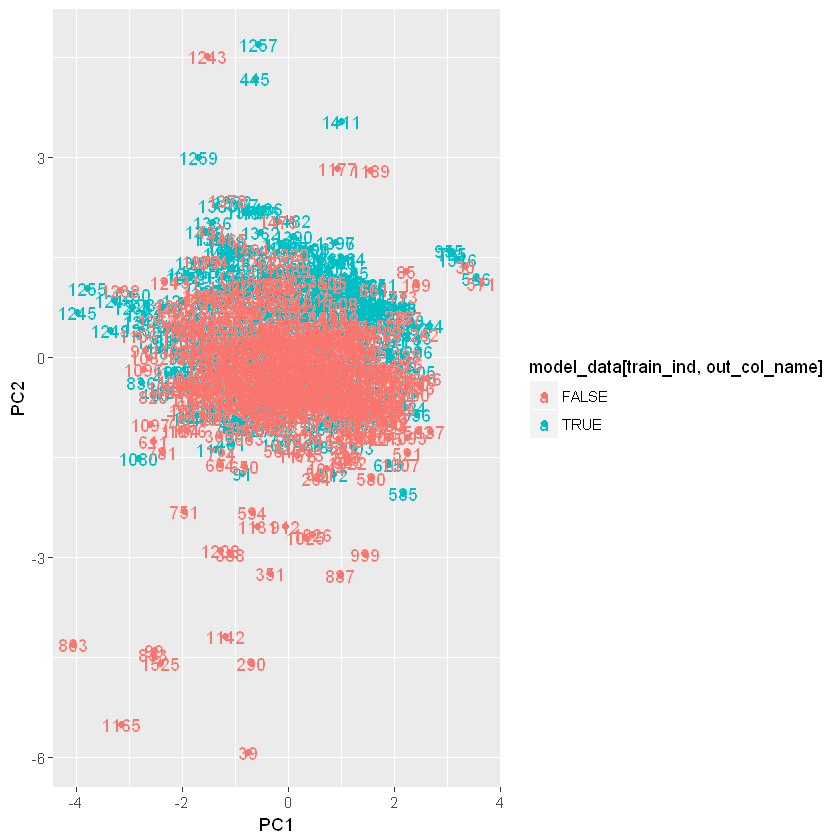

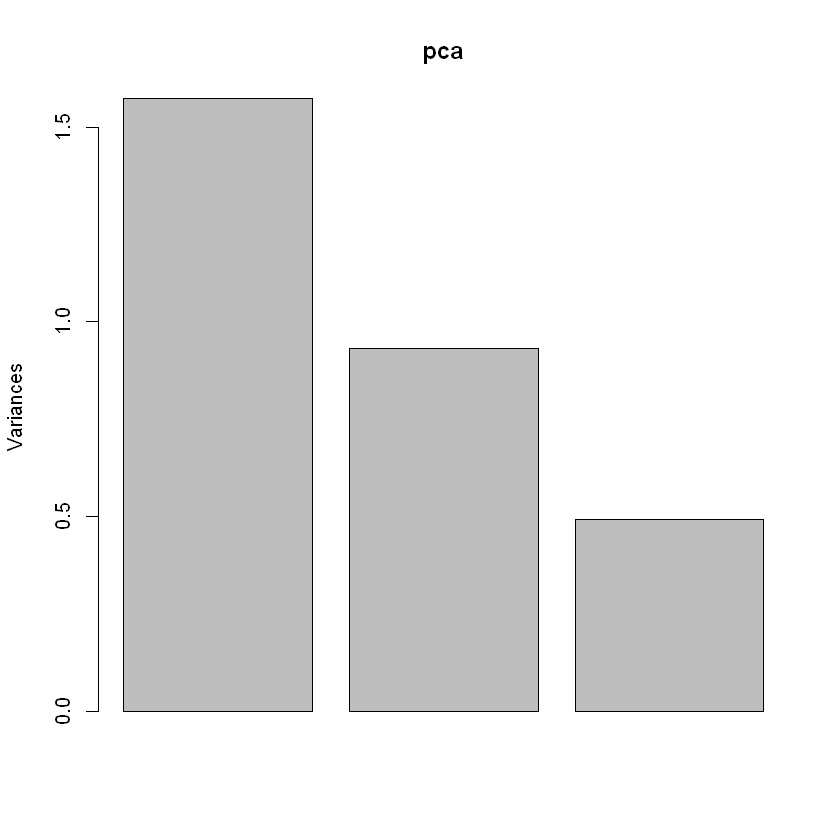

In [17]:
pca = prcomp(train_normalized)
pca$x = -pca$x
pca$rotation=-pca$rotation
p = ggplot(pca$x[,c(1,2)], aes(x=PC1, y=PC2, colour=model_data[train_ind, out_col_name], label=rownames(pca$x)))
p + geom_point() + geom_text()
print(pca)
plot(pca)

In [18]:
trn_preprocessed = predict(pca, train_normalized)
tst_preprocessed = predict(pca, test_normalized)
trn_in = trn_preprocessed
tst_in = tst_preprocessed

In [22]:
train_data = cbind(as.data.frame(trn_in), flood_pt = model_data[train_ind, out_col_name])
fmla = as.formula(paste(out_col_name, "~", paste(colnames(trn_in), collapse="+")))
fmla

flood_pt ~ PC1 + PC2 + PC3

### KNN

In [23]:
kfit = knn(trn_in, tst_in, trn_out, k=5)
table(tst_out, kfit)

       kfit
tst_out FALSE TRUE
  FALSE   147   93
  TRUE     90  134

### SVM

In [25]:
svm_fit = svm(fmla, data=train_data)
svm_pred = predict(svm_fit, tst_in)
table(tst_out, svm_pred)

       svm_pred
tst_out FALSE TRUE
  FALSE   200   40
  TRUE    118  106

### Decision Trees

In [100]:
dt_fmla = as.formula(paste(out_col_name, "~", paste(in_col_names, collapse="+")))
dt_train_data = model_data[train_ind, ]
dt_test_data = model_data[test_ind, in_col_names]

In [101]:
fit = rpart(dt_fmla, method='class', data=dt_train_data, minsplit=2)
printcp(fit)


Classification tree:
rpart(formula = dt_fmla, data = dt_train_data, method = "class", 
    minsplit = 2)

Variables actually used in tree construction:
[1] dist_to_ba dist_to_wa elev_1     imp        Rim_Elevat Structure1 twi       
[8] Year_Insta

Root node error: 476/991 = 0.48032

n= 991 

        CP nsplit rel error  xerror     xstd
1 0.264706      0   1.00000 1.00000 0.033042
2 0.028361      1   0.73529 0.80462 0.032204
3 0.011555      3   0.67857 0.78992 0.032091
4 0.010504     10   0.56933 0.75840 0.031826
5 0.010000     12   0.54832 0.75420 0.031788


png 
  2

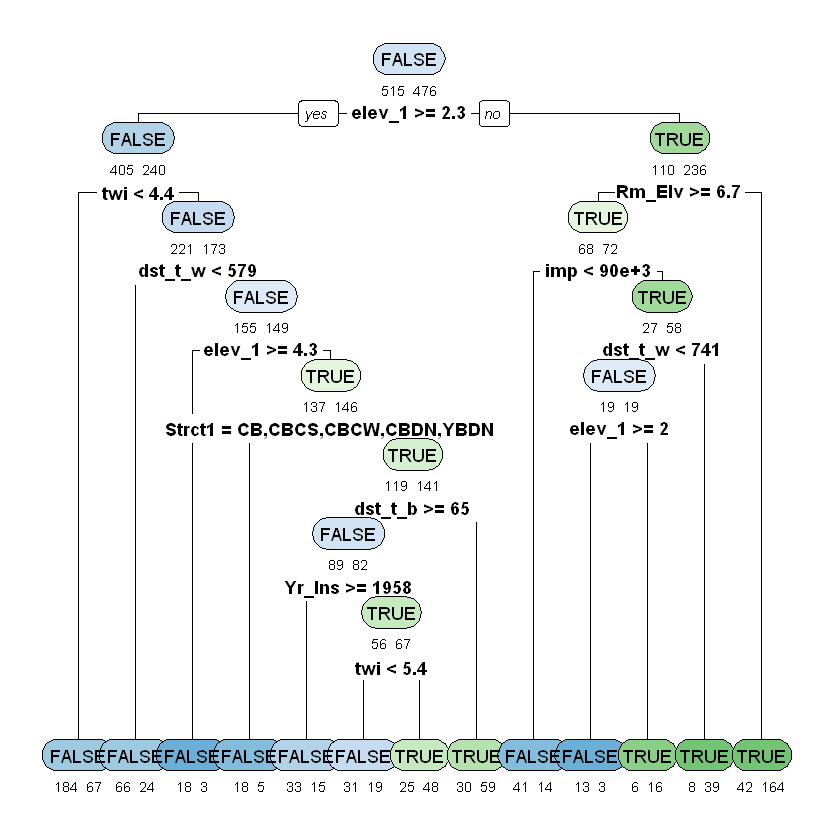

In [102]:
tiff(paste(fig_dir, "Plot2.tif"), width=9, height=6, units='in', res = 300)
rpart.plot(fit, under=TRUE, cex=0.9, extra=1, varlen = 6)
dev.off()
rpart.plot(fit, under=TRUE, cex=0.9, extra=1, varlen = 6)

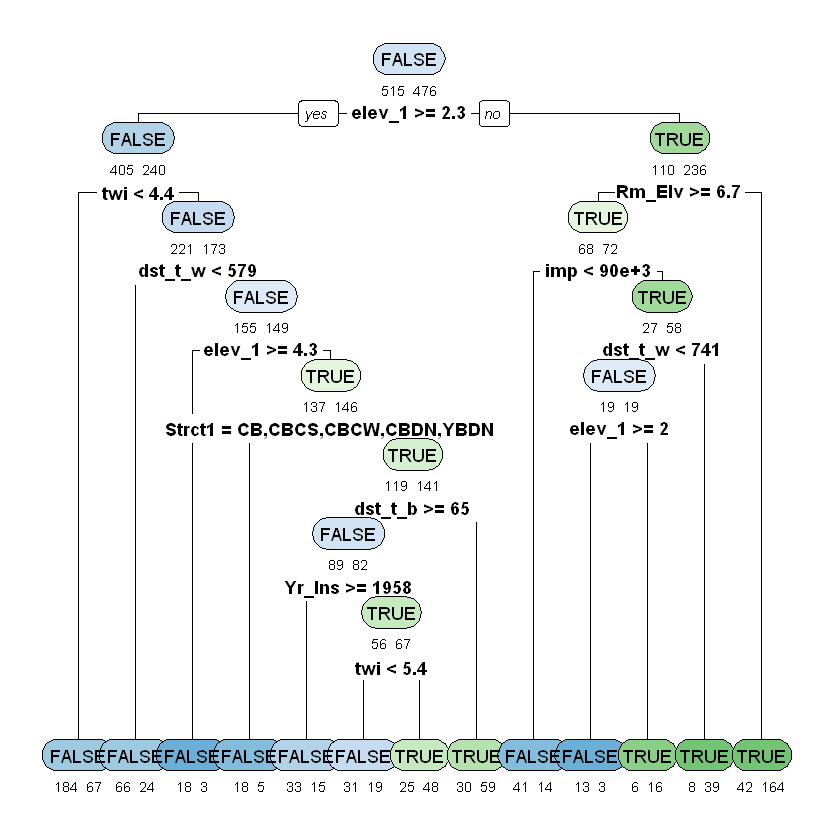

In [103]:
pfit<- prune(fit, cp=fit$cptable[which.min(fit$cptable[,"xerror"]),"CP"])
rpart.plot(pfit, under=TRUE, cex=0.9, extra=1, varlen = 6)

#### Decision Tree training results

In [104]:
pred = predict(pfit, dt_train_data[, in_col_names], type = 'class')
table(trn_out, pred)

       pred
trn_out FALSE TRUE
  FALSE   285  230
  TRUE    269  207

#### Decision Tree testing results

In [105]:
pred = predict(pfit, dt_test_data, type = 'class')
table(tst_out, pred)

       pred
tst_out FALSE TRUE
  FALSE   166   54
  TRUE     76  128

### Random Forests

In [106]:
forest = randomForest(dt_fmla, data = dt_train_data, importance = TRUE, type="classification", nodesize=2)

pred = predict(forest, dt_train_data[, in_col_names])
table(trn_out, pred)

       pred
trn_out FALSE TRUE
  FALSE   264  251
  TRUE    250  226

In [109]:
pred = predict(forest, dt_test_data)
table(tst_out, pred)
forest$importance

       pred
tst_out FALSE TRUE
  FALSE   169   51
  TRUE     77  127

,FALSE,TRUE,MeanDecreaseAccuracy,MeanDecreaseGini
elev_1,1.762066e-02,0.0554310561,3.571858e-02,65.274548
dist_to_ba,7.026823e-03,0.0106344697,8.762638e-03,48.509414
imp,1.145150e-02,0.0018680410,6.904298e-03,43.990341
dist_to_wa,7.486210e-03,0.0022663974,4.983980e-03,46.215599
Structure1,2.149479e-03,-0.0014402295,4.210414e-04,8.491170
twi,1.221525e-02,0.0116243757,1.196499e-02,51.662126
Rim_Elevat,7.301353e-03,0.0401009724,2.306298e-02,52.305862
Invert_Ele,1.330799e-02,0.0092826484,1.134488e-02,45.026319
Year_Insta,1.176166e-02,0.0015974838,6.870577e-03,33.261467
Pipe_Geome,2.656481e-03,-0.0027624498,2.985294e-05,8.930468


### Logistic Regression

In [34]:
lo_fit = glm(fmla, family=binomial(link='logit'), data=train_data)
print(lo_fit)


Call:  glm(formula = fmla, family = binomial(link = "logit"), data = train_data)

Coefficients:
(Intercept)          PC1          PC2          PC3  
   -0.08967      0.02007      0.84345     -0.40332  

Degrees of Freedom: 1082 Total (i.e. Null);  1079 Residual
Null Deviance:	    1500 
Residual Deviance: 1371 	AIC: 1379


In [35]:
pred = predict(lo_fit, as.data.frame(tst_in), type="response")
table(tst_out, round(pred)>0)

       
tst_out FALSE TRUE
  FALSE   170   70
  TRUE     90  134